<a href="https://colab.research.google.com/github/saman-nia/Deep-Learning-for-Dimensionality-Reduction/blob/master/Dense%20Matrix%20Dimensionality%20Reduction/Comparing_with_Tech_Wine.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Author: Saman Paidar Nia

In [0]:
!pip install tensorflow-gpu==2.0.0-alpha0

In [0]:
# Import libraries.
import tensorflow as tf
from tensorflow.python.ops import control_flow_ops
#-----------------------------------------------------------
import numpy
import warnings
import math
import scipy
import pandas
#-----------------------------------------------------------
from scipy.spatial.distance import squareform, pdist
from math import sqrt
from IPython.display import clear_output
#------------------------------------------------------------
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import preprocessing
from sklearn import cluster
from sklearn.metrics import normalized_mutual_info_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import pairwise
from sklearn.neighbors import NearestNeighbors
from sklearn import datasets
#------------------------------------------------------------
import matplotlib.pyplot as plt
from tqdm import tqdm
import difflib
import operator
import random
#------------------------------------------------------------
warnings.filterwarnings('ignore')

In [3]:
print('Version of Tensorflow: ', tf.__version__)

Version of Tensorflow:  2.0.0-alpha0


In [0]:
# Compute pairwise distances between observations in n-dimensional space.
class Similarity_Graph:
  def get_matrix(self, data, similar_method):
    X = preprocessing.normalize(data, norm='l2', axis=0)
    X = squareform(pdist(X, str(similar_method)))
    return X

In [0]:
class Similarity_Dataset_Iterator():
  def __init__(self, data, labels, similarity, similarity_method):
    self.data = data
    self.labels = labels
    self.similarity_method = similarity_method
    self.matrix = Similarity_Graph.get_matrix(self, data=self.data, similar_method=self.similarity_method)
    self.data_size = self.matrix.shape[0]
    self.current_index = 0
  def next_batch(self, num):
    data=self.matrix.transpose()
    labels=self.labels
    idx = numpy.arange(0, len(data))
    numpy.random.shuffle(idx)
    idx = idx[:num]
    data_shuffle = [data[ i] for i in idx]
    labels_shuffle = [labels[ i] for i in idx]
    return data_shuffle, labels_shuffle
  def whole_dataset(self):
    return (self.matrix.transpose(), self.labels)

In [0]:
def read_data(similarity, similarity_method):
  data = datasets.load_wine()
  X = data.data
  y = data.target
  list_target_name = list(data.target_names)
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
  Similarity_X = Similarity_Dataset_Iterator(X_train, y_train, similarity, similarity_method)    
  return (X_train, y_train, X_test, y_test, list_target_name, Similarity_X)

In [0]:
similarity_methods = ['cosine','correlation','euclidean','sqeuclidean',
                      'mahalanobis','chebyshev','canberra','braycurtis','cityblock']

In [0]:
def list_similarity_methods():
  for jjj in range(len(similarity_methods)):
    print('{:d} : {}'.format(jjj+1, similarity_methods[jjj]))
  print('\n')

In [9]:
list_similarity_methods()
while True:
  similarity_ = input('Please insert code of your desired similarity distance'
                      'measurment from the list above:\n'
                      'e.g. type: 1, then press enter.\n'                     
                      '***Blank value for Correlation Distance.***\n'
                      'Enter here: ')
  try:
    similarity_ = int(similarity_)
    if 1 <= similarity_ <= len(similarity_methods):
      similarity_method = similarity_methods[similarity_-1]
      print('You selected: ', similarity_method)
      break
    else:
      print('Please insert number between 1 to 9 ...')      
  except ValueError:
    similarity_method = 'correlation'
    print('You selected: ', similarity_method)
    break

1 : cosine
2 : correlation
3 : euclidean
4 : sqeuclidean
5 : mahalanobis
6 : chebyshev
7 : canberra
8 : braycurtis
9 : cityblock


Please insert code of your desired similarity distancemeasurment from the list above:
e.g. type: 1, then press enter.
***Blank value for Correlation Distance.***
Enter here: 
You selected:  correlation


In [0]:
X_train, y_train, X_test, y_test, list_target_name, train_set = read_data(Similarity_Graph(), similarity_method)

In [11]:
n_input = train_set.data_size 
print('Number of sample are: ', n_input)

Number of sample are:  142


In [12]:
print('Number of features before similarity matrix are:  ', X_train.shape[1])
print('Number of features after similarity matrix are:   ', n_input)


Number of features before similarity matrix are:   13
Number of features after similarity matrix are:    142


In [0]:
n_groups = len(numpy.unique(y_train))

In [0]:
def find_geometric_value():
  geometric_value = 2
  while n_input > geometric_value:
    geometric_value = geometric_value * 2
  geometric_value = geometric_value / 2
  return int(geometric_value)

In [0]:
def find_max_layers(embedded_node):    
  if embedded_node is None:
    embedded_node = int(2)
  next_layer = find_geometric_value()
  count_layers = 0
  while next_layer >= embedded_node:
    count_layers += 1
    next_layer = next_layer / 2
  max_layers = count_layers - 1
  print ('The embedded goal of dimension is:------------------------- ', embedded_node)
  print ('The maximum possibility of having of hiedden layers is:---- ', max_layers)
  print ('Number of nodes in the first hidden layer is:-------------- ', find_geometric_value())
  return str(embedded_node), max_layers, find_geometric_value()

In [16]:
while True:
  value = input('Please Enter your Final Dimension and press Enter:\n'
                'Valid range, please: From 2 onwards\n'
                'Any invalid input, will be considered as 2\n')
  try:
    value = int(value)
    break
  except ValueError:
    value = 2
    break
n_code, n_max_layers, first_layer = find_max_layers(embedded_node = value)

Please Enter your Final Dimension and press Enter:
Valid range, please: From 2 onwards
Any invalid input, will be considered as 2

The embedded goal of dimension is:-------------------------  2
The maximum possibility of having of hiedden layers is:----  6
Number of nodes in the first hidden layer is:--------------  128


In [0]:
n_hidden_layer = [first_layer]
geometric_progress = first_layer
for i in range(1, n_max_layers):
  geometric_progress = int(geometric_progress / 2)
  n_hidden_layer.append(geometric_progress)

In [0]:
def get_hidden_layer(num_hidden = n_max_layers):
  if num_hidden is None:
    num_hidden = int(n_max_layers)
  num_nodes = n_input+sum(n_hidden_layer[:num_hidden])+int(n_code)
  print("Graph Encoder looks like this:")
  print("Input:--------------------->:",n_input)
  print("Hidden Layers are:--------->:",n_hidden_layer[:num_hidden])
  print("Embedded Goal-------------->:",n_code)
  print("Number of Hidden Layers:--->:",num_hidden)
  print("Number of Layers:---------->:",len(n_hidden_layer[:num_hidden])+2)
  print("Number of Nodes:----------->:",num_nodes)
  print("Number of Groups:---------->:",n_groups)
  return n_hidden_layer[:num_hidden], num_nodes

In [19]:
run_ghl = False
while True:  
  if run_ghl == False:
    value_hl = input('Please Enter the number of hidden layers and press Enter:\n'
                      'Valid range, please: From 1 to {:d} \n'
                       'Any invalid input, will be considered'
                     'as {:d} \n'.format(n_max_layers, round(sqrt(n_max_layers))))
    run_ghl = True
  else:
    value_hl = input()
  try:
    if (1 <= int(value_hl) <= n_max_layers):
      value_hl = int(value_hl)
      break
    else:
      print('Please insert valid value or press enter without value:')
  except ValueError:
    value_hl = round(sqrt(n_max_layers))
    break
num_hidden_layers, num_nodes = get_hidden_layer(num_hidden = value_hl)

Please Enter the number of hidden layers and press Enter:
Valid range, please: From 1 to 6 
Any invalid input, will be consideredas 2 

Graph Encoder looks like this:
Input:--------------------->: 142
Hidden Layers are:--------->: [128, 64]
Embedded Goal-------------->: 2
Number of Hidden Layers:--->: 2
Number of Layers:---------->: 4
Number of Nodes:----------->: 336
Number of Groups:---------->: 3


In [0]:
scope_layer = []
for i in range(1, len(num_hidden_layers)+1):
  new_word = "hidden-layer-"
  character = str(i)
  new_word += character
  scope_layer.append(new_word)

In [0]:
def encoder(x, n_code, mode_train):
    with tf.compat.v1.variable_scope("encoder"):
      hidden = [None] * len(num_hidden_layers)
      for ii in range(len(num_hidden_layers)):
        if scope_layer[ii] == 'hidden-layer-1':
          with tf.compat.v1.variable_scope(scope_layer[ii]):
            hidden[ii] = layer_sigmoid(x, [n_input, num_hidden_layers[ii]],
                                       [num_hidden_layers[ii]], mode_train)
        else:
          with tf.compat.v1.variable_scope(scope_layer[ii]):
            hidden[ii] = layer_sigmoid(hidden[ii-1], [num_hidden_layers[ii-1],
                                                      num_hidden_layers[ii]],
                                       [num_hidden_layers[ii]], mode_train)  
      with tf.compat.v1.variable_scope("embedded"):
        code = layer_sigmoid(hidden[-1], [num_hidden_layers[-1], n_code],
                             [n_code], mode_train)
    return code

In [0]:
def decoder(code, n_code, mode_train):
    with tf.compat.v1.variable_scope("decoder"):
      hidden = [None] * len(num_hidden_layers)
      for ii in range(len(num_hidden_layers)):
        if scope_layer[ii] == 'hidden-layer-1':
          with tf.compat.v1.variable_scope(scope_layer[ii]):
            hidden[ii] = layer_sigmoid(code, [n_code, num_hidden_layers[-1]],
                                       [num_hidden_layers[-1]], mode_train)
        else:
          with tf.compat.v1.variable_scope(scope_layer[ii]):
            hidden[ii] = layer_sigmoid(hidden[ii-1], [num_hidden_layers[-(ii)],
                                                      num_hidden_layers[-(ii+1)]],
                                       [num_hidden_layers[-(ii+1)]], mode_train)        
      with tf.compat.v1.variable_scope("reconstructed"):
        output = layer_sigmoid(hidden[-1], [num_hidden_layers[0], n_input],
                               [n_input], mode_train)
    return output

In [0]:
def batch_norm(x, n_out, mode_train):
    beta_initialize = tf.compat.v1.constant_initializer(value=0.1, dtype=tf.float32)
    gamma_initialize = tf.compat.v1.constant_initializer(value=1.0, dtype=tf.float32)
    beta = tf.compat.v1.get_variable("beta", [n_out], initializer=beta_initialize)
    gamma = tf.compat.v1.get_variable("gamma", [n_out], initializer=gamma_initialize)
    batch_mean, batch_var = tf.nn.moments(x=x, axes=[0], name='moments')
    ema = tf.train.ExponentialMovingAverage(decay=0.5)
    ema_apply_op = ema.apply([batch_mean, batch_var])
    ema_mean, ema_var = ema.average(batch_mean), ema.average(batch_var)
    def mean_var():
        with tf.control_dependencies([ema_apply_op]):
            return tf.identity(batch_mean), tf.identity(batch_var)
    mean, var = control_flow_ops.cond(mode_train, mean_var, lambda: (ema_mean, ema_var))
    return tf.nn.batch_normalization(x, mean, var, beta, gamma, 1e-08) 

In [0]:
def layer_sigmoid(input, weight_shape, bias_shape, mode_train):
    weight_initialize = tf.compat.v1.random_normal_initializer(stddev = (1.0 / weight_shape[0] ** 0.5))
    bias_initialize = tf.compat.v1.random_normal_initializer(stddev = (1.0 / bias_shape[0] ** 0.5))
    w = tf.compat.v1.get_variable("w", weight_shape, initializer = weight_initialize)
    b = tf.compat.v1.get_variable("b", bias_shape, initializer = bias_initialize)
    return tf.nn.sigmoid(batch_norm((tf.matmul(input, w) + b), weight_shape[1], mode_train))

In [0]:
def layer_tanh(input, weight_shape, bias_shape, mode_train):
    weight_initialize = tf.compat.v1.random_normal_initializer(stddev = (1.0 / weight_shape[0] ** 0.5))
    bias_initialize = tf.compat.v1.random_normal_initializer(stddev = (1.0 / bias_shape[0] ** 0.5))
    w = tf.compat.v1.get_variable("w", weight_shape, initializer = weight_initialize)
    b = tf.compat.v1.get_variable("b", bias_shape, initializer = bias_initialize)
    return tf.nn.tanh(batch_norm((tf.matmul(input, w) + b), weight_shape[1], mode_train))

In [0]:
def layer_softmax(input, weight_shape, bias_shape, mode_train):
    weight_initialize = tf.compat.v1.random_normal_initializer(stddev = (1.0 / weight_shape[0] ** 0.5))
    bias_initialize = tf.compat.v1.random_normal_initializer(stddev = (1.0 / bias_shape[0] ** 0.5))
    w = tf.compat.v1.get_variable("w", weight_shape, initializer = weight_initialize)
    b = tf.compat.v1.get_variable("b", bias_shape, initializer = bias_initialize)
    return tf.nn.softmax(batch_norm((tf.matmul(input, w) + b), weight_shape[1], mode_train))

In [0]:
def layer_relu(input, weight_shape, bias_shape, mode_train):
    weight_initialize = tf.compat.v1.random_normal_initializer(stddev = (1.0 / weight_shape[0] ** 0.5))
    bias_initialize = tf.compat.v1.random_normal_initializer(stddev = (1.0 / bias_shape[0] ** 0.5))
    w = tf.compat.v1.get_variable("w", weight_shape, initializer = weight_initialize)
    b = tf.compat.v1.get_variable("b", bias_shape, initializer = bias_initialize)
    return tf.nn.relu(batch_norm((tf.matmul(input, w) + b), weight_shape[1], mode_train))

In [0]:
def loss_function(reconstructed, x):
  with tf.compat.v1.variable_scope("train"):
    t = tf.math.subtract(x, reconstructed)
    t = tf.math.square(t)
    t = tf.math.reduce_sum(t)
    t = tf.math.reduce_mean(t)
    return t

In [0]:
def training(cost, learning_rate, beta1, beta2, global_step):
    optimizer = tf.compat.v1.train.AdamOptimizer(learning_rate, beta1, beta2,
                                                 epsilon=1e-08, use_locking=False,
                                                 name='Adam')
    compute_gradient = optimizer.compute_gradients(cost)
    apply_gradient = optimizer.apply_gradients(compute_gradient, global_step=global_step)
    return apply_gradient

In [0]:
def k_means(X, n_clusters):
    kmeans = cluster.KMeans(n_clusters=n_clusters)
    return kmeans.fit(X).labels_

In [0]:
data_set, labels_set = train_set.whole_dataset() #---- Allocation of data and labels

In [0]:
n_kneighbors = 3
def knn_samples(X, n_kneighbors):
  nbrs = NearestNeighbors(n_neighbors = n_kneighbors).fit(X)
  distances, indices = nbrs.kneighbors(X)
  return indices
index_input = knn_samples(X_train, n_kneighbors)

In [0]:
# Parameters
n_layers = (value_hl + 2) #------------------------ Number of Layers.
beta1 = 0.9 #-------------------------------------- Decay rate 1.  
beta2 = 0.99 #------------------------------------- Decay rate 2
learning_rate = 0.001 #---------------------------- Learning rate.
n_batch = n_layers  #------------------------------ Number of selection data in per step.
epochs = 50 # ------------------------------ Number of Epochs.
n_interior = n_input // n_batch

In [34]:
print('Number of Samples are: -------------------------->',n_input)
print('Number of Embedded Goal-------------------------->',n_code)
print('Number of epochs are: --------------------------->',epochs)
print('Number of batch sizes are: ---------------------->',n_batch)
print('Number of Backpropagation in each epoch is: ----->',n_interior)


Number of Samples are: --------------------------> 142
Number of Embedded Goal--------------------------> 2
Number of epochs are: ---------------------------> 50
Number of batch sizes are: ----------------------> 4
Number of Backpropagation in each epoch is: -----> 35


In [0]:
with tf.Graph().as_default():
  with tf.compat.v1.variable_scope("autoencoder_architecture"):
    x = tf.compat.v1.placeholder("float", [None, n_input])   
    mode_train = tf.compat.v1.placeholder(tf.bool)
    code = encoder(x, int(n_code), mode_train)
    reconstructed = decoder(code, int(n_code), mode_train)
    cost = loss_function(reconstructed, x)
    global_step = tf.Variable(0, name='global_step', trainable=False)
    train_optimizer = training(cost, learning_rate, beta1, beta2, global_step)
    sess = tf.compat.v1.Session()
    init_op = tf.compat.v1.initializers.global_variables()
    sess.run(init_op)

In [0]:
patience_cnt = 0
patience = 5

In [0]:
loss_cost=[] #------- A list to keep all training evaluations.
steps=[] #----------- A list to keep all steps.
NMI_step = [] #------ A list to keep all NMI progresses.
l_mean = []
k_mean = []
list_pvals = []
list_rhos = []

In [38]:
# Training cycle
for epoch in tqdm(range(epochs)):
  for interior in range(n_interior):
    # Fit training with Backpropagation using batch data.
    miniData, _ = train_set.next_batch(n_batch)
    _, new_cost = sess.run([train_optimizer, cost], feed_dict={x: miniData,
                                                               mode_train:True})    
    #------------------------- Save the optimized data -------------------------
  steps.append(epoch)
  loss_cost.append(new_cost)
  ae_codes = sess.run(code, feed_dict={x: data_set, mode_train: False})
  pred_KMeans_code = k_means(ae_codes, n_groups)
  nmi_KMeans_code = normalized_mutual_info_score(labels_set, pred_KMeans_code)
  NMI_step.append(nmi_KMeans_code*100)
  index_code = knn_samples(ae_codes, n_kneighbors)
  list_rho = []
  list_pval = []
  list_r = []
  for qq in range(len(index_input)):    
    sm = difflib.SequenceMatcher(None, index_input[qq], index_code[qq])
    list_r.append(sm.quick_ratio())
    rho, pval = scipy.stats.spearmanr(index_input[qq], index_code[qq])
    list_rho.append(rho)
    list_pval.append(pval)  
  list_rhos.append(numpy.mean(list_rho)*100)
  list_pvals.append(numpy.mean(list_pval)*100)
  l_mean.append(numpy.mean(list_r)*100)
  # early stopping
  '''
  if epoch > 50:    
    min_delta = 0.1   
    if l_mean[epoch-1] - l_mean[epoch] > min_delta or l_mean[epoch-2] - l_mean[epoch] > min_delta:
      patience_cnt += 1 
    else:
      patience_cnt = 0 
    if patience_cnt > patience:
      print("early stopping on step {}.".format(epoch))
      break
      '''

100%|██████████| 50/50 [00:17<00:00,  3.01it/s]


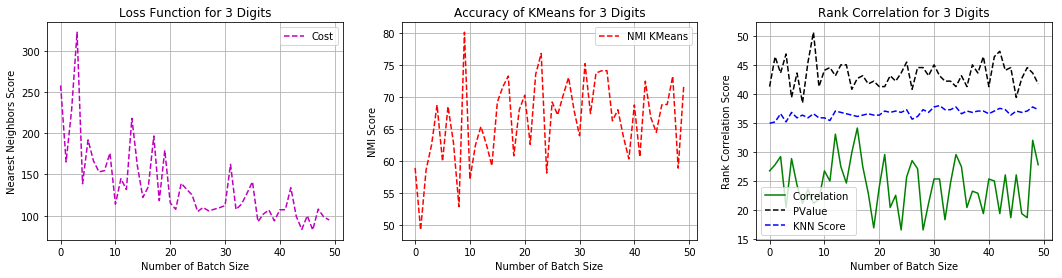


Number of original dataset dimension are: -------> 13
Number of samples are: --------------------------> 142
Number of embedded goal--------------------------> 2
Number of epochs are: ---------------------------> 50
Number of batch sizes are: ----------------------> 4


In [39]:
xi = [i for i in range(0, len(steps))]
plt.figure(figsize=(18,4))
plt.subplot(1,3,1)
plt.plot(loss_cost, color='m', linestyle='--', label = 'Cost')
plt.xlabel('Number of Batch Size'),plt.ylabel('Nearest Neighbors Score')
plt.title('Loss Function for {:d} Digits'.format(n_groups))
plt.grid()
plt.legend()
plt.subplot(1,3,2)
plt.plot(NMI_step, color='r', linestyle='--', label = 'NMI KMeans')
plt.xlabel('Number of Batch Size'),plt.ylabel('NMI Score')
plt.title('Accuracy of KMeans for {:d} Digits'.format(n_groups))
plt.grid()
plt.legend()
plt.subplot(1,3,3)
plt.plot(list_rhos, color='g', linestyle='-', label = 'Correlation ')
plt.plot(list_pvals, color='k', linestyle='--', label = 'PValue')
plt.plot(l_mean, color='b', linestyle='--', label = 'KNN Score')
plt.xlabel('Number of Batch Size'),plt.ylabel('Rank Correlation Score')
plt.title('Rank Correlation for {:d} Digits'.format(n_groups))
plt.grid()
plt.legend()
plt.show()
print('\nNumber of original dataset dimension are: ------->',X_train.shape[1])
print('Number of samples are: -------------------------->',n_input)
print('Number of embedded goal-------------------------->',n_code)
print('Number of epochs are: --------------------------->',epochs)
print('Number of batch sizes are: ---------------------->',n_batch)

In [0]:
sorted_color = ['deepskyblue','dimgray','forestgreen','fuchsia','b','gold',
                'ghostwhite','gold','goldenrod','gray','green','greenyellow',
                'grey','honeydew','hotpink','indianred','y']
sorted_color = sorted_color[:n_groups]
markers_list = ["o","v","8","h","p","*"] * 5
markers_list = markers_list[:n_groups]

In [0]:
ae_codes = sess.run(code, feed_dict={x: data_set, mode_train: False})

In [0]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_train)
pred_KMeans_pca = k_means(X_pca, n_groups)
nmi_KMeans_pca = normalized_mutual_info_score(labels_set, pred_KMeans_pca)

In [0]:
from sklearn.manifold import SpectralEmbedding
spec_embed = SpectralEmbedding(n_components=2)
X_spec_embed = spec_embed.fit_transform(X_train)
pred_KMeans_spec_embed = k_means(X_spec_embed, n_groups)
nmi_KMeans_spec_embed = normalized_mutual_info_score(labels_set, pred_KMeans_spec_embed)

In [0]:
from sklearn.manifold import LocallyLinearEmbedding
LLE = LocallyLinearEmbedding(n_components=2)
X_LLE = LLE.fit_transform(X_train)
pred_KMeans_LLE = k_means(X_LLE, n_groups)
nmi_KMeans_LLE = normalized_mutual_info_score(labels_set, pred_KMeans_LLE)

In [0]:
from sklearn.manifold import Isomap
isomap = Isomap(n_components=2)
X_isomap = isomap.fit_transform(X_train)
pred_KMeans_isomap = k_means(X_isomap, n_groups)
nmi_KMeans_isomap = normalized_mutual_info_score(labels_set, pred_KMeans_isomap)

In [0]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2)
X_tsne = tsne.fit_transform(X_train)
pred_KMeans_tsne = k_means(X_tsne, n_groups)
nmi_KMeans_tsne = normalized_mutual_info_score(labels_set, pred_KMeans_tsne)

In [0]:
from sklearn.decomposition import KernelPCA
KPCA = KernelPCA(n_components=2)
X_KPCA = KPCA.fit_transform(X_train)
pred_KMeans_KPCA = k_means(X_KPCA, n_groups)
nmi_KMeans_KPCA = normalized_mutual_info_score(labels_set, pred_KMeans_KPCA)

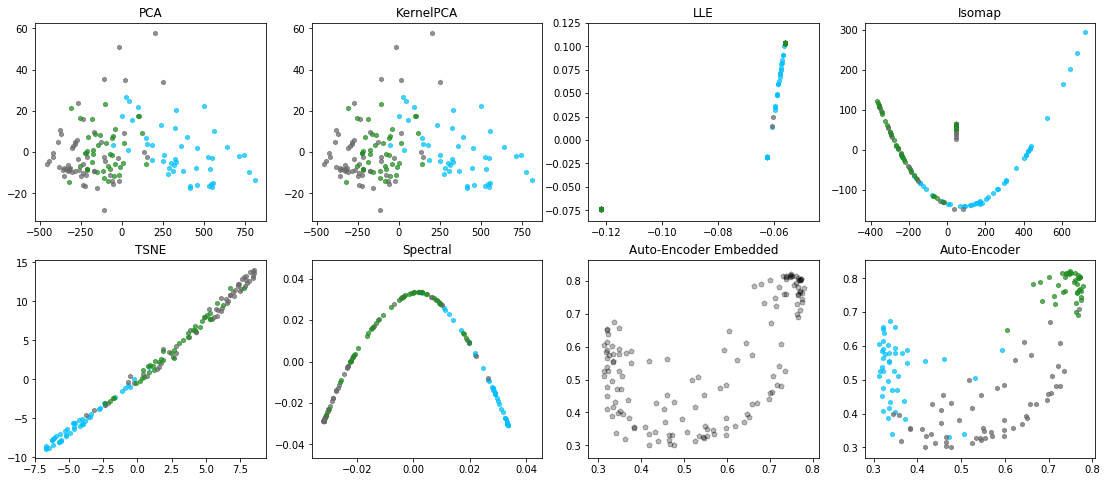

In [48]:
plt.figure(figsize=(19,8))
for num in range(n_groups):
  plt.subplot(2,4,1)  
  plt.scatter([X_pca[:,0][i] for i in range(len(labels_set)) if labels_set[i] == num],
              [X_pca[:,1][i] for i in range(len(labels_set)) if labels_set[i] == num],
              20, color = sorted_color[num], alpha=0.7, marker='h')
  plt.title('PCA')
  plt.subplot(2,4,2)
  plt.scatter([X_KPCA[:,0][i] for i in range(len(labels_set)) if labels_set[i] == num],
              [X_KPCA[:,1][i] for i in range(len(labels_set)) if labels_set[i] == num],
              20, color = sorted_color[num], alpha=0.7, marker='h')
  plt.title('KernelPCA')  
  plt.subplot(2,4,3)
  plt.scatter([X_LLE[:,0][i] for i in range(len(labels_set)) if labels_set[i] == num],
              [X_LLE[:,1][i] for i in range(len(labels_set)) if labels_set[i] == num],
              20, color = sorted_color[num], alpha=0.7, marker='h')
  plt.title('LLE')
  plt.subplot(2,4,4)
  plt.scatter([X_isomap[:,0][i] for i in range(len(labels_set)) if labels_set[i] == num],
              [X_isomap[:,1][i] for i in range(len(labels_set)) if labels_set[i] == num],
              20, color = sorted_color[num], alpha=0.7, marker='h')
  plt.title('Isomap')
  plt.subplot(2,4,5)
  plt.scatter([X_tsne[:,0][i] for i in range(len(labels_set)) if labels_set[i] == num],
              [X_tsne[:,1][i] for i in range(len(labels_set)) if labels_set[i] == num],
              20, color = sorted_color[num], alpha=0.7, marker='h')
  plt.title('TSNE')
  plt.subplot(2,4,6)
  plt.scatter([X_spec_embed[:,0][i] for i in range(len(labels_set)) if labels_set[i] == num],
              [X_spec_embed[:,1][i] for i in range(len(labels_set)) if labels_set[i] == num],
              20, color = sorted_color[num], alpha=0.7, marker='h')
  plt.title('Spectral')  
  plt.subplot(2,4,7)
  plt.scatter(ae_codes[:,0], ae_codes[:,1], 30, color='k', alpha=0.1, marker='p')
  plt.title('Auto-Encoder Embedded')
  plt.subplot(2,4,8)
  plt.scatter([ae_codes[:,0][i] for i in range(len(labels_set)) if labels_set[i] == num],
              [ae_codes[:,1][i] for i in range(len(labels_set)) if labels_set[i] == num],
              20, color = sorted_color[num], alpha=0.7, marker='h')
  plt.title('Auto-Encoder')
plt.show()

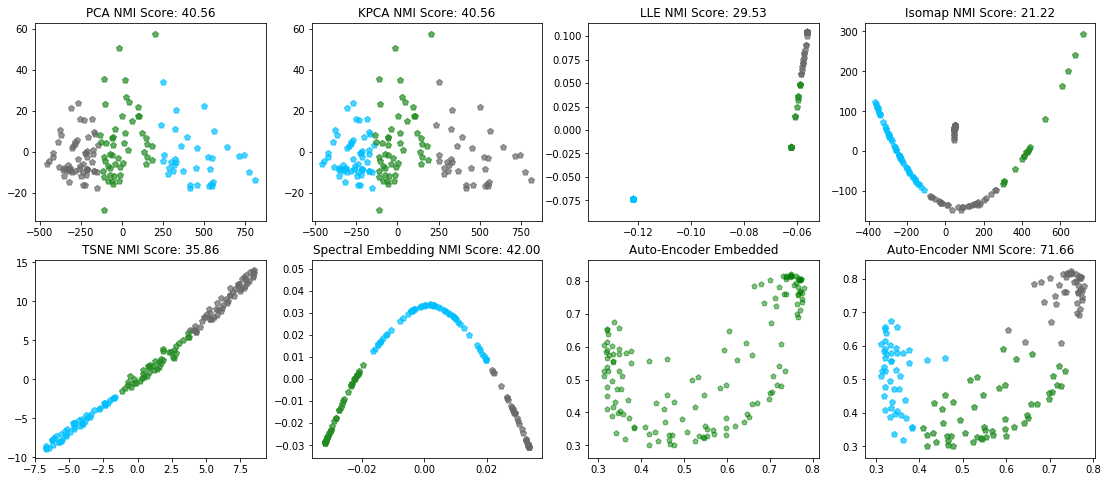

In [49]:
plt.figure(figsize=(19,8))
for num in range(n_groups):
  plt.subplot(2,4,1)  
  plt.scatter([X_pca[:,0][i] for i in range(len(pred_KMeans_pca)) if pred_KMeans_pca[i] == num],
              [X_pca[:,1][i] for i in range(len(pred_KMeans_pca)) if pred_KMeans_pca[i] == num],
              40, color = sorted_color[num], alpha=0.7, marker='p')
  plt.title(('PCA NMI Score: {:0.2f}').format(nmi_KMeans_pca*100))
  plt.subplot(2,4,2)
  plt.scatter([X_KPCA[:,0][i] for i in range(len(pred_KMeans_KPCA)) if pred_KMeans_KPCA[i] == num],
              [X_KPCA[:,1][i] for i in range(len(pred_KMeans_KPCA)) if pred_KMeans_KPCA[i] == num],
              40, color = sorted_color[num], alpha=0.7, marker='p')
  plt.title(('KPCA NMI Score: {:0.2f}').format(nmi_KMeans_KPCA*100))
  plt.subplot(2,4,3)
  plt.scatter([X_LLE[:,0][i] for i in range(len(pred_KMeans_LLE)) if pred_KMeans_LLE[i] == num],
              [X_LLE[:,1][i] for i in range(len(pred_KMeans_LLE)) if pred_KMeans_LLE[i] == num],
              40, color = sorted_color[num], alpha=0.7, marker='p')
  plt.title(('LLE NMI Score: {:0.2f}').format(nmi_KMeans_LLE*100))
  plt.subplot(2,4,4)
  plt.scatter([X_isomap[:,0][i] for i in range(len(pred_KMeans_isomap)) if pred_KMeans_isomap[i] == num],
              [X_isomap[:,1][i] for i in range(len(pred_KMeans_isomap)) if pred_KMeans_isomap[i] == num],
              40, color = sorted_color[num], alpha=0.7, marker='p')
  plt.title(('Isomap NMI Score: {:0.2f}').format(nmi_KMeans_isomap*100))
  plt.subplot(2,4,5)
  plt.scatter([X_tsne[:,0][i] for i in range(len(pred_KMeans_tsne)) if pred_KMeans_tsne[i] == num],
              [X_tsne[:,1][i] for i in range(len(pred_KMeans_tsne)) if pred_KMeans_tsne[i] == num],
              40, color = sorted_color[num], alpha=0.7, marker='p')
  plt.title(('TSNE NMI Score: {:0.2f}').format(nmi_KMeans_tsne*100))
  plt.subplot(2,4,6)
  plt.scatter([X_spec_embed[:,0][i] for i in range(len(pred_KMeans_spec_embed)) if pred_KMeans_spec_embed[i] == num],
              [X_spec_embed[:,1][i] for i in range(len(pred_KMeans_spec_embed)) if pred_KMeans_spec_embed[i] == num],
              40, color = sorted_color[num], alpha=0.7, marker='p')
  plt.title(('Spectral Embedding NMI Score: {:0.2f}').format(nmi_KMeans_spec_embed*100))
  plt.subplot(2,4,7)
  plt.scatter(ae_codes[:,0], ae_codes[:,1], 30, color='g', alpha=0.2, marker='p')
  plt.title('Auto-Encoder Embedded')
  plt.subplot(2,4,8)
  plt.scatter([ae_codes[:,0][i] for i in range(len(pred_KMeans_code)) if pred_KMeans_code[i] == num],
              [ae_codes[:,1][i] for i in range(len(pred_KMeans_code)) if pred_KMeans_code[i] == num],
              40, color = sorted_color[num], alpha=0.7, marker='p')
  plt.title(('Auto-Encoder NMI Score: {:0.2f}').format(nmi_KMeans_code*100))
plt.show()

In [0]:
from sklearn import svm
from sklearn import metrics
import matplotlib
import matplotlib.cm as cm
from matplotlib.colors import ListedColormap

In [51]:
_X_train, _X_test, _y_train, _y_test = train_test_split(ae_codes, labels_set, test_size=0.25, random_state=42)
clf = svm.LinearSVC().fit(_X_train, _y_train)
_Xtrain, _Xtest, _ytrain, _ytest = train_test_split(X_train, y_train, test_size=0.25, random_state=42)
clf1 = svm.LinearSVC().fit(_Xtrain, _ytrain)
accuracyAE = metrics.accuracy_score(_y_test, clf.predict(_X_test))
accuracyML = metrics.accuracy_score(_ytest, clf1.predict(_Xtest))
print("\nAccuracy on embedded code with {:d} dimensions is {:0.2f}%".format(ae_codes.shape[1], 100 * accuracyAE))
print("\nAccuracy on original dataset with {:d} dimensions is {:0.2f}%".format(X_train.shape[1], 100 * accuracyML))


Accuracy on embedded code with 2 dimensions is 97.22%

Accuracy on original dataset with 13 dimensions is 94.44%


In [0]:
clf = svm.SVC(kernel='linear')
models = clf.fit(ae_codes, labels_set)

In [0]:
def plot_decision_regions(X, y, classifier, resolution=0.01):
    # setup marker generator and color map
    cmap = ListedColormap(sorted_color)
    # plot the decision surface
    x1_min, x1_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
    x2_min, x2_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5
    xx1, xx2 = numpy.meshgrid(numpy.arange(x1_min, x1_max, resolution),
                              numpy.arange(x2_min, x2_max, resolution))
    Z = classifier.predict(numpy.array([xx1.ravel(), xx2.ravel()]).T)
    Z = Z.reshape(xx1.shape)
    plt.contourf(xx1, xx2, Z, alpha=0.2, cmap=cmap)
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())
    for idx, cl in enumerate(numpy.unique(y)):
        plt.scatter(x = X[y == cl, 0], y = X[y == cl, 1],
                    alpha = 0.9, c = sorted_color[idx], label=list_target_name[idx], 
                    marker = markers_list[idx])
    plt.legend(loc='best')
    plt.title('Linear Support Vector Machine')
    plt.show()

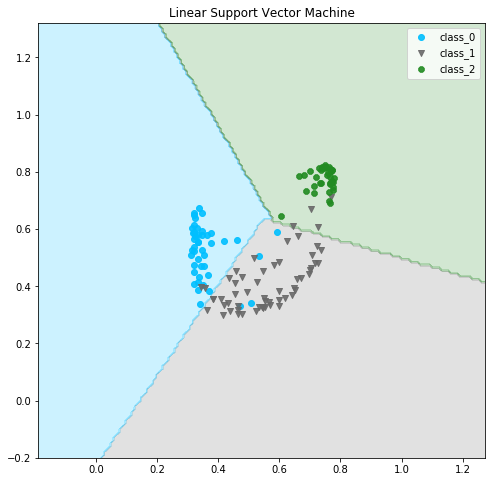

In [54]:
plt.figure(figsize=(8, 8))
plot_decision_regions(ae_codes, labels_set, classifier=models)

In [0]:
def collect_new_samples(X, y):
  new_X_list = []
  new_y_list = []
  lable_new = random.randint(0, n_groups-1)
  for i in range(len(y)):    
    if y[i] == lable_new:
      new_X_list.append(X[i])
      new_y_list.append(y[i])
  return numpy.array(new_X_list), numpy.array(new_y_list).ravel()

In [0]:
def new_sample(similarity, X, y):
  X, y = collect_new_samples(X, y)
  categories_lables_test = []
  categories_lables_test = list_target_name.copy()
  markers_list_test = markers_list.copy()
  sorted_color_test = sorted_color.copy()
  data = X_train.copy()
  labels = y_train.copy()  
  for i in range(len(X)):
    index, __ = max(enumerate(pairwise.cosine_similarity(X_train, X[i:i+1])),
                    key=operator.itemgetter(1))
    data[index] = X[i]
    labels[index] = n_groups
  categories_lables_test.append('New Instance = ' + list_target_name[(y[0])])
  markers_list_test.append("X")
  sorted_color_test.append("r")
    
  Similarity_X_test = Similarity_Dataset_Iterator(data, labels, similarity, similarity_method)
  return Similarity_X_test, categories_lables_test, markers_list_test, sorted_color_test

In [0]:
train_set_test, categories_lables_test, markers_list_test, sorted_color_test = new_sample(
    Similarity_Graph(), X_test, y_test)

In [0]:
data_set_test, labels_set_test = train_set_test.whole_dataset() #---- Allocation of data and labels
ae_codes_test = sess.run(code, feed_dict={x: data_set_test, mode_train: False})

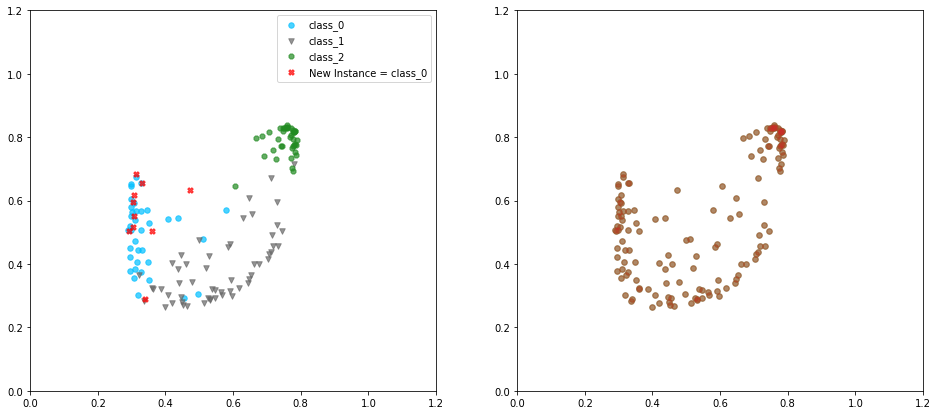

In [59]:
plt.figure(figsize=(16,7))
for num in range(n_groups+1):
  plt.subplot(1,2,1)
  plt.ylim(bottom=0, top=1.2)
  plt.xlim(left=0, right=1.2)
  plt.scatter([ae_codes_test[:,0][i] for i in range(len(labels_set_test)) if labels_set_test[i] == num],
              [ae_codes_test[:,1][i] for i in range(len(labels_set_test)) if labels_set_test[i] == num],
              30, label=categories_lables_test[num], color = sorted_color_test[num], alpha=0.7, marker=markers_list_test[num])
  plt.legend(loc='best')
  plt.subplot(1,2,2)
  plt.ylim(bottom=0, top=1.2)
  plt.xlim(left=0, right=1.2)
  plt.scatter([ae_codes_test[:,0][i] for i in range(len(labels_set_test))],
              [ae_codes_test[:,1][i] for i in range(len(labels_set_test))],
              30, alpha=0.3, marker="o")
plt.show()